# Doobydobap Channel Analysis

In [2]:
# Import libraries

import googleapiclient.discovery
import json
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# to hide developer key

import DoobydobapConfig.config as config

In [3]:
# Create youtube object

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = config.DEVELOPER_KEY

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

doobydobap = 'UCh8gHdtzO2tXd593_bjErWg'

In [4]:
# function uses youtube API to get specified channel data

def get_channel_data(youtube, channel):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel
    )
    response = request.execute()
    return response

In [5]:
# get dooby channel stats and pretty print json output

dooby_stats = get_channel_data(youtube, doobydobap)

print(json.dumps(dooby_stats, indent=4, sort_keys=True))

{
    "etag": "fIPmZ_3lAG20YkZdk24p3yXPKrg",
    "items": [
        {
            "contentDetails": {
                "relatedPlaylists": {
                    "likes": "",
                    "uploads": "UUh8gHdtzO2tXd593_bjErWg"
                }
            },
            "etag": "-BvvUFVb6I6B0OlUXTg6flbgDoQ",
            "id": "UCh8gHdtzO2tXd593_bjErWg",
            "kind": "youtube#channel",
            "snippet": {
                "country": "US",
                "customUrl": "doobydobap",
                "description": "Hi, I\u2019m Tina, aka Doobydobap!\n\nFood is the medium I use to tell stories and connect with people who share the same passion as I do. Whether it\u2019s because you\u2019re hungry at midnight or trying to learn how to cook, I hope you enjoy watching my content and recipes. Don't yuck my yum!\n\nwww.doobydobap.com\n",
                "localized": {
                    "description": "Hi, I\u2019m Tina, aka Doobydobap!\n\nFood is the medium I use to tell storie

In [6]:
# retrieve key for all of dooby's uploads

dooby_uploads_key = dooby_stats['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [7]:
# function gets all video keys from uploads playlist

def get_dooby_videos(youtube, playlistId):
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=playlistId,
        maxResults = 50
    )
    response = request.execute()
    video_ids = []
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlistId,
                maxResults = 50,
                pageToken = next_page_token
            )
            
            response = request.execute()
            
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                
            next_page_token = response.get('nextPageToken')

    return video_ids

In [ ]:
# create array with all video ids

dooby_video_ids = get_dooby_videos(youtube, dooby_uploads_key)

print(json.dumps(dooby_video_ids, indent=1))

In [9]:
# gets specified data about all videos passed

def get_dooby_video_stats(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,statistics,contentDetails',
            id=",".join(video_ids[i:i+50])
        )
        
        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'],
                               Date_published = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comments = video['statistics']['commentCount'],
                               Duration = video['contentDetails']['duration'])
            all_video_stats.append(video_stats)
    
    return all_video_stats

In [ ]:
# create dictionary with all video data

dooby_video_stats = get_dooby_video_stats(youtube, dooby_video_ids)

print(json.dumps(dooby_video_stats, indent=4, sort_keys=True))

In [11]:
# create dataframe

dooby_df = pd.DataFrame(dooby_video_stats)

dooby_df

,Title,Date_published,Views,Likes,Comments,Duration
0,The Muffin Man,2022-03-12T00:28:40Z,282887,12507,842,PT17M32S
1,Flying to London,2022-03-09T22:27:43Z,438724,19003,1294,PT17M58S
2,What I ate Flying Business Class Korean Air 🇰🇷...,2022-03-08T07:38:14Z,2648720,269764,1381,PT58S
3,(not so) Teenage Angst,2022-03-02T16:26:23Z,415419,18369,1398,PT22M56S
4,can't smell :s,2022-02-26T15:12:43Z,318715,14779,1240,PT14M35S
...,...,...,...,...,...,...
138,"KOREAN STREET FOOD VLOG #1// Gwangjang Market,...",2021-04-18T18:30:09Z,318865,11882,433,PT10M38S
139,CHILI OIL BIANG BIANG NOODLES,2021-04-03T22:11:29Z,1394865,84434,571,PT50S
140,Chorizo Kimchi Fried Rice,2021-03-27T00:10:14Z,130405,5626,161,PT6M59S
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27T01:21:44Z,223395,8799,345,PT8M40S


In [12]:
# check data types

dooby_df.dtypes

Title             object
Date_published    object
Views             object
Likes             object
Comments          object
Duration          object
dtype: object

In [13]:
# convert all data types to data types that accurately reflect data and add year and month column

dooby_df['Title'] = dooby_df['Title'].astype("string")

dooby_df['Date_published'] = pd.to_datetime(dooby_df['Date_published']).dt.date

dooby_df['Views'] = pd.to_numeric(dooby_df['Views'])

dooby_df['Likes'] = pd.to_numeric(dooby_df['Likes'])

dooby_df['Comments'] = pd.to_numeric(dooby_df['Comments'])

dooby_df['Duration'] = dooby_df['Duration'].astype("string")

dooby_df['year'] = pd.DatetimeIndex(dooby_df['Date_published']).year

dooby_df['month'] = pd.DatetimeIndex(dooby_df['Date_published']).month

In [14]:
# check to make sure it worked

dooby_df.dtypes

Title             string
Date_published    object
Views              int64
Likes              int64
Comments           int64
Duration          string
year               int64
month              int64
dtype: object

In [15]:
# make a copy so any original dataframe is preserved

normalized_dooby_df = dooby_df.copy()

In [16]:
# function to normalize data with min max scaling

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [17]:
# normalize numerical data columns

normalized_dooby_df['Views'] = min_max_scaling(normalized_dooby_df['Views'])

normalized_dooby_df['Likes'] = min_max_scaling(normalized_dooby_df['Likes'])

normalized_dooby_df['Comments'] = min_max_scaling(normalized_dooby_df['Comments'])

In [18]:
# also going to convert duration column to just numbers so can do something with it

def convert_to_digits(series):
    new_string = ""
    for c in series:
        if c.isdigit():
            new_string += c
    return new_string

In [19]:
normalized_dooby_df["Duration"] = normalized_dooby_df["Duration"].apply(convert_to_digits)

normalized_dooby_df["Duration"] = pd.to_numeric(normalized_dooby_df["Duration"])

normalized_dooby_df['Duration'] = min_max_scaling(normalized_dooby_df['Duration'])

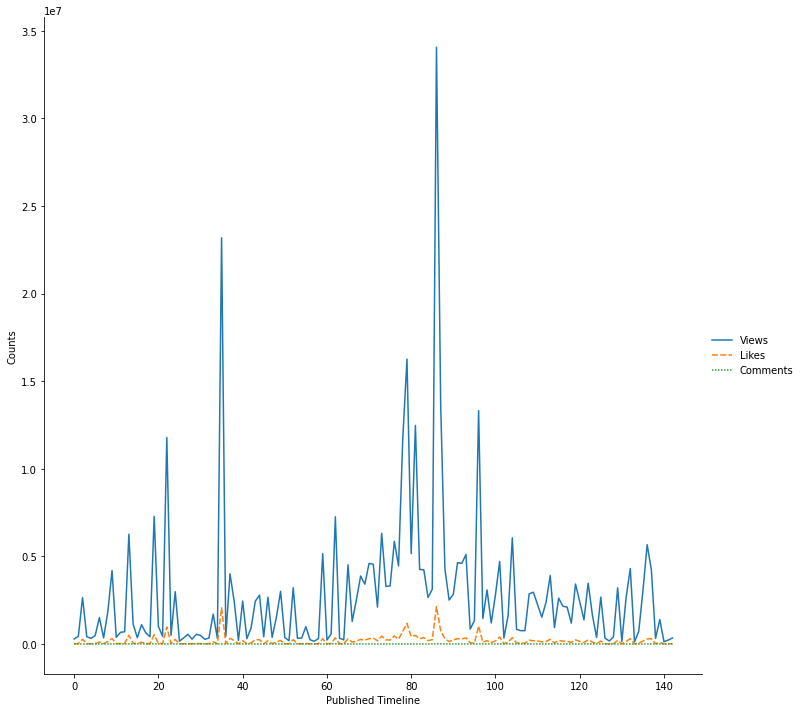

In [20]:
# graph of unmodified data, as you can see views dwarfs other data

regular_graph = sns.relplot(data=dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10)

regular_graph.set(xlabel="Published Timeline", ylabel="Counts")

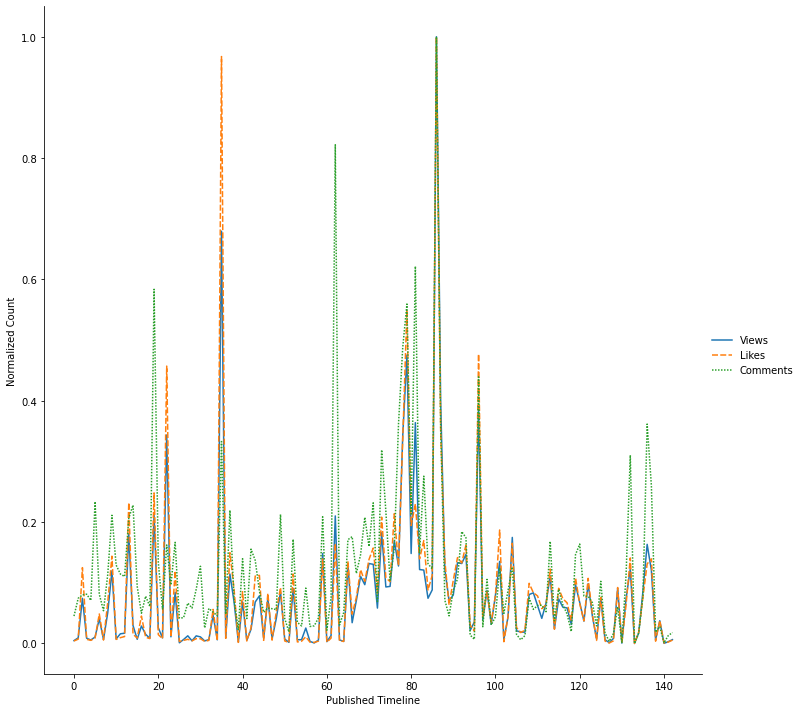

In [21]:
# graph of normalized data to get a better idea of how stuff is performing with each other

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Likes', 'Comments']], kind="line", height=10)

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count")

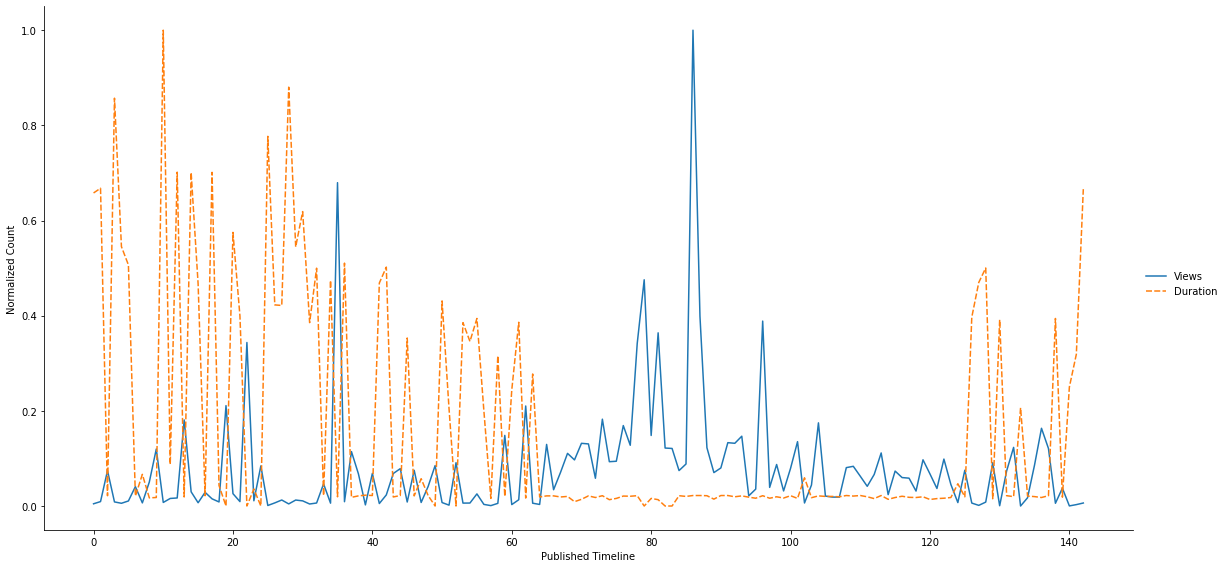

In [22]:
# graph to show relationship between views and duration

normalized_graph = sns.relplot(data=normalized_dooby_df[['Views', 'Duration']], kind="line", height=8, aspect=2)

normalized_graph.set(xlabel="Published Timeline", ylabel="Normalized Count")

In [23]:
dooby_df.sort_values('Views', ascending=False).head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
86,Do You Ever Dream About.. Chili Oil Ramen?,2021-09-27,34057171,2131238,15562,PT59S,2021,9
35,Nostalgia is a powerful ingredient,2021-11-30,23183284,2061872,5277,PT52S,2021,11
79,What I Ate for Lunch in 7/11 Korea,2021-10-06,16257901,1173253,8772,PT1M,2021,10
87,GARLIC WHOLE FRIED CHICKEN,2021-09-24,13659811,752628,5662,PT59S,2021,9
96,This is what I ate in a gas stop in Korea,2021-09-06,13312133,1018786,6919,PT58S,2021,9
81,My biggest fear when posting content,2021-10-05,12474490,493400,9730,PT36S,2021,10
22,Cadaver Dissection,2022-01-05,11784118,976478,2649,PT1M,2022,1
78,I can't believe that I didn't want this before,2021-10-07,11719048,717601,7664,PT58S,2021,10
19,Deal Breakers,2022-01-12,7283155,531738,9145,PT1M,2022,1
62,"How I stay ""skinny""",2021-10-22,7256503,353811,12818,PT45S,2021,10


In [24]:
dooby_df.sort_values('Views').head(20)

,Title,Date_published,Views,Likes,Comments,Duration,year,month
133,KOREAN STREET FOOD VLOG #2 l Noryangjin Fish M...,2021-05-29,123816,3868,146,PT5M44S,2021,5
140,Chorizo Kimchi Fried Rice,2021-03-27,130405,5626,161,PT6M59S,2021,3
130,KOREAN STREET FOOD VLOG #3 | Jeju 5 Day Market,2021-06-05,143070,5228,172,PT10M31S,2021,6
57,Moody & Tacos l NYC Vlog,2021-10-28,152175,7485,595,PT4M3S,2021,10
25,21 lessons from 2021 l Craziest year so far,2021-12-31,160848,10862,793,PT20M45S,2021,12
127,Corn Rice and Miso Soup,2021-06-18,169894,5363,200,PT12M37S,2021,6
51,"Second to Last Day-- empanadas, estella, and a...",2021-11-07,185151,7104,437,PT5M39S,2021,11
39,"Seoul Vlog - brunch, my first interview, eatin...",2021-11-24,203278,7638,495,PT6M1S,2021,11
141,Tonkotsu Ramen - Behind the Scenes,2021-02-27,223395,8799,345,PT8M40S,2021,2
60,Eating at Hip n Cool Restos l NYC Vlog,2021-10-25,224508,8067,482,PT6M42S,2021,10
